<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/vae-segmentation/notebooks/Segmentation_DFC2020_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation downstream task: SEN12FLOOD

Model: ResNetUnet \\
Data: SEN12FLOOD \\
Pretrained weights: dependent on pretext tasks



### Environment setup

In [1]:
# !pip install metrics

In [2]:
# !pip install segmentation-models-pytorch
# !pip install pytorch-lightning==1.5.4

In [3]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@vae-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision vae-segmentation) to /tmp/pip-install-c4y1hn8_/ssl-remote-sensing_99567136b3284e89bcd77de5f0f00181
  Running command git clone -q https://github.com/AlexanderLontke/ssl-remote-sensing.git /tmp/pip-install-c4y1hn8_/ssl-remote-sensing_99567136b3284e89bcd77de5f0f00181
  Running command git checkout -b vae-segmentation --track origin/vae-segmentation
  Switched to a new branch 'vae-segmentation'
  Branch 'vae-segmentation' set up to track remote branch 'vae-segmentation' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 20.9 MB 18.3 MB/s 
     |████████████████████████████████| 798 kB 97.7 MB/s 
     |████████████████████████████████| 329 kB 

In [4]:
!pip install rasterio torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# !pip install wandb

In [6]:
# # from ssl_remote_sensing.downstream_tasks.segmentatio
from ssl_remote_sensing.data.dfc2020 import DFC2020
from ssl_remote_sensing.downstream_tasks.segmentation.utils import patch_first_conv, get_metrics
from ssl_remote_sensing.downstream_tasks.segmentation.model import ResNetUNet
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility
from ssl_remote_sensing.constants import RANDOM_INITIALIZATION
from ssl_remote_sensing.pretext_tasks.utils import (
    load_encoder_checkpoint_from_pretext_model,
)

/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapContr

In [7]:
# import rasterio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score
import gdown
import tarfile

/usr/local/lib/python3.8/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [8]:
# import wandb
# wandb.login()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# RANDOM_INITIALIZATION

In [12]:
# g_drive_path = "/content/drive/MyDrive/deep_learning_checkpoints"
# check_point_paths = os.listdir(g_drive_path)
# check_point_paths += [RANDOM_INITIALIZATION]
# check_point_paths = [g_drive_path + "/" + x for x in check_point_paths]
# check_point_paths

### Hyperparameter setup

In [13]:
# # Model Setup
# class Hparams:
#     def __init__(self):
#         self.epochs = 10 # number of training epochs for pretext tasks
#         self.seed = 1234  # randomness seed
#         self.save = "./saved_model"
#         self.gradient_accumulation_steps = 1  # gradient accumulation steps
#         self.batch_size = 16
#         self.lr = 1e-3
#         self.weight_decay = 1e-6
#         self.latent_dim = 256
#         self.optim = "Adam"
#         self.embedding_size = 128  # papers value is 128
#         self.temperature = 0.5  # 0.1 or 0.5
#         self.weight_decay = 1e-6
#         self.cuda = True  # use coda
#         self.transform = False
#         self.split = False

In [14]:
# train_config = Hparams()

In [15]:
# reproducibility(train_config)

## Data

In [16]:
dfc2020_path = '/content/drive/MyDrive/dfc2020/dfc_2020.tar.gz'

In [17]:
with tarfile.open(dfc2020_path, mode="r") as tar:
    tar.extractall(path='/content/')

In [18]:
import os
import rasterio
import numpy as np
import glob
import torch.utils.data as data
import matplotlib.pyplot as plt
from tqdm import tqdm

class DFC2020(data.Dataset):
    """PyTorch dataset class for the DFC2020 dataset"""

    def __init__(self,
                 path,
                 subset="val",
                 no_savanna=False,
                 use_s2hr=False,
                 use_s2mr=False,
                 use_s2lr=False,
                 use_s1=False):
        """Initialize the dataset"""

        # inizialize
        super(DFC2020, self).__init__()

        # make sure parameters are okay
        if not (use_s2hr or use_s2mr or use_s2lr or use_s1):
            raise ValueError("No input specified, set at least one of "
                             + "use_[s2hr, s2mr, s2lr, s1] to True!")
        self.use_s2hr = use_s2hr
        self.use_s2mr = use_s2mr
        self.use_s2lr = use_s2lr
        self.use_s1 = use_s1
        assert subset in ["val", "test"]
        self.no_savanna = no_savanna

        # provide number of input channels
        self.n_inputs = get_ninputs(use_s1, use_s2hr, use_s2mr, use_s2lr)

        # provide index of channel(s) suitable for previewing the input
        self.display_channels, self.brightness_factor = get_display_channels(
                                                            use_s2hr,
                                                            use_s2mr,
                                                            use_s2lr)

        # provide number of classes
        if no_savanna:
            self.n_classes = max(DFC2020_CLASSES) - 1
        else:
            self.n_classes = max(DFC2020_CLASSES)

        # make sure parent dir exists
        assert os.path.exists(path)

        # build list of sample paths
        if subset == "val":
            path = os.path.join(path, "ROIs0000_validation", "s2_validation")
        else:
            path = os.path.join(path, "ROIs0000_test", "s2_0")
        s2_locations = glob.glob(os.path.join(path, "*.tif"), recursive=True)
        self.samples = []
        for s2_loc in tqdm(s2_locations, desc="[Load]"):
            s1_loc = s2_loc.replace("_s2_", "_s1_").replace("s2_", "s1_")
            lc_loc = s2_loc.replace("_dfc_", "_lc_").replace("s2_", "dfc_")
            self.samples.append({"lc": lc_loc, "s1": s1_loc, "s2": s2_loc,
                                 "id": os.path.basename(s2_loc)})

        # sort list of samples
        self.samples = sorted(self.samples, key=lambda i: i['id'])

        print("loaded", len(self.samples),
              "samples from the dfc2020 subset", subset)

    def __getitem__(self, index):
        """Get a single example from the dataset"""

        # get and load sample from index file
        sample = self.samples[index]
        return load_sample(sample, self.use_s1, self.use_s2hr, self.use_s2mr,
                           self.use_s2lr, no_savanna=self.no_savanna,
                           igbp=False)

    def __len__(self):
        """Get number of samples in the dataset"""
        return len(self.samples)

    def visualize_observation(self,idx):
        sample = self.__getitem__(idx)
        img = sample["image"]
        label = sample["label"]

        print("id:", sample["id"], "\n",
          "input shape:", img.shape, "\n",
          "label shape:", label.shape, "\n")

        fig, axs = plt.subplots(1, 2, figsize=(10, 6))

        img_rgb = img[[3, 2, 1], :, :]
        img_rgb = np.transpose(img_rgb, (1, 2, 0))
        img_rgb = img_rgb / img_rgb.max()

        axs[0].imshow(img_rgb)
        axs[0].set_title("Sentinel-2 RGB")
        axs[0].axis("off")

        mask = label.squeeze()

        axs[1].imshow(mask)
        axs[1].set_title("Groundtruth Mask")
        axs[1].axis("off")

        plt.show()

#mapping from igbp to dfc2020 classes
DFC2020_CLASSES = [
    0,  # class 0 unused in both schemes
    1,
    1,
    1,
    1,
    1,
    2,
    2,
    3,  # --> will be masked if no_savanna == True
    3,  # --> will be masked if no_savanna == True
    4,
    5,
    6,  # 12 --> 6
    7,  # 13 --> 7
    6,  # 14 --> 6
    8,
    9,
    10
    ]

# indices of sentinel-2 high-/medium-/low-resolution bands
S2_BANDS_HR = [2, 3, 4, 8]
S2_BANDS_MR = [5, 6, 7, 9, 12, 13]
S2_BANDS_LR = [1, 10, 11]

# util function for reading s2 data
def load_s2(path, use_hr, use_mr, use_lr):
    bands_selected = []
    if use_hr:
        bands_selected = bands_selected + S2_BANDS_HR
    if use_mr:
        bands_selected = bands_selected + S2_BANDS_MR
    if use_lr:
        bands_selected = bands_selected + S2_BANDS_LR
    bands_selected = sorted(bands_selected)
    with rasterio.open(path) as data:
        s2 = data.read(bands_selected)
    s2 = s2.astype(np.float32)
    s2 = np.clip(s2, 0, 10000)
    s2 /= 10000
    s2 = s2.astype(np.float32)
    return s2

# util function for reading s1 data
def load_s1(path):
    with rasterio.open(path) as data:
        s1 = data.read()
    s1 = s1.astype(np.float32)
    s1 = np.nan_to_num(s1)
    s1 = np.clip(s1, -25, 0)
    s1 /= 25
    s1 += 1
    s1 = s1.astype(np.float32)
    return s1

# util function for reading lc data
def load_lc(path, no_savanna=False, igbp=True):

    # load labels
    with rasterio.open(path) as data:
        lc = data.read(1)

    # convert IGBP to dfc2020 classes
    if igbp:
        lc = np.take(DFC2020_CLASSES, lc)
    else:
        lc = lc.astype(np.int64)

    # adjust class scheme to ignore class savanna
    if no_savanna:
        lc[lc == 3] = 0
        lc[lc > 3] -= 1

    # convert to zero-based labels and set ignore mask
    lc -= 1
    lc[lc == -1] = 255
    return lc

# util function for reading data from single sample
def load_sample(sample, use_s1, use_s2hr, use_s2mr, use_s2lr,
                no_savanna=False, igbp=True, unlabeled=False):

    use_s2 = use_s2hr or use_s2mr or use_s2lr

    # load s2 data
    if use_s2:
        img = load_s2(sample["s2"], use_s2hr, use_s2mr, use_s2lr)

    # load s1 data
    if use_s1:
        if use_s2:
            img = np.concatenate((img, load_s1(sample["s1"])), axis=0)
        else:
            img = load_s1(sample["s1"])

    # load label
    if unlabeled:
        return {'image': img, 'id': sample["id"]}
    else:
        lc = load_lc(sample["lc"], no_savanna=no_savanna, igbp=igbp)

        return {'image': img, 'label': lc, 'id': sample["id"]}

# util function for reading data from single sample
def load_sample_visual(sample, use_s1, use_s2hr, use_s2mr, use_s2lr,
                no_savanna=False, igbp=True, unlabeled=False):

    use_s2 = use_s2hr or use_s2mr or use_s2lr

    # load s2 data
    if use_s2:
        img = load_s2(sample["s2"], use_s2hr, use_s2mr, use_s2lr)

    # load s1 data
    if use_s1:
        if use_s2:
            img = np.concatenate((img, load_s1(sample["s1"])), axis=0)
        else:
            img = load_s1(sample["s1"])

    # load label
    if unlabeled:
        return {'image': img, 'id': sample["id"]}
    else:
        lc = torch.tensor(load_lc(sample["lc"], no_savanna=no_savanna, igbp=igbp))

        return {'image': img, 'label': lc, 'id': sample["id"]}

# calculate number of input channels
def get_ninputs(use_s1, use_s2hr, use_s2mr, use_s2lr):
    n_inputs = 0
    if use_s2hr:
        n_inputs += len(S2_BANDS_HR)
    if use_s2mr:
        n_inputs += len(S2_BANDS_MR)
    if use_s2lr:
        n_inputs += len(S2_BANDS_LR)
    if use_s1:
        n_inputs += 2
    return n_inputs

# select channels for preview images
def get_display_channels(use_s2hr, use_s2mr, use_s2lr):
    if use_s2hr and use_s2lr:
        display_channels = [3, 2, 1]
        brightness_factor = 3
    elif use_s2hr:
        display_channels = [2, 1, 0]
        brightness_factor = 3
    elif not (use_s2hr or use_s2mr or use_s2lr):
        display_channels = 0
        brightness_factor = 1
    else:
        display_channels = 0
        brightness_factor = 3
    return (display_channels, brightness_factor)

In [19]:
# # subset - 'val' 986
# # subset - 'test' 5128

# # train_set for sentinel-2|
# trainset = DFC2020('/content/dfc_data', subset="test", use_s1=False, use_s2lr=True, use_s2hr=True,
#                  use_s2mr=True, no_savanna=True)
# valset = DFC2020('/content/dfc_data', subset="val", use_s1=False, use_s2lr=True, use_s2hr=True,
#                  use_s2mr=True, no_savanna=True)

In [20]:
from torch.utils.data import random_split

In [21]:
dataset = DFC2020('/content/dfc_data', subset="test", use_s1=False, use_s2lr=True, use_s2hr=True,
                 use_s2mr=True, no_savanna=True)
trainset, valset = random_split(dataset, [4102, 1026])

[Load]: 100%|██████████| 5128/5128 [00:00<00:00, 520683.42it/s]

loaded 5128 samples from the dfc2020 subset test


id: ROIs0000_test_s2_0_p1150.tif 
 input shape: (13, 256, 256) 
 label shape: (256, 256) 



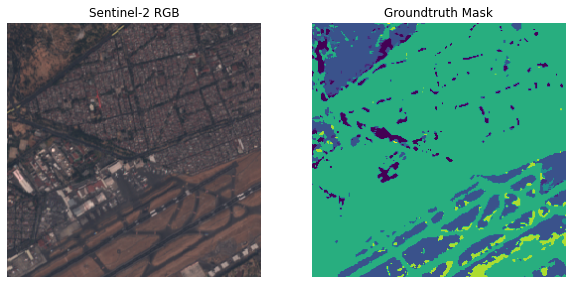

In [22]:
dataset.visualize_observation(170)

In [23]:
train_loader = DataLoader(trainset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)
val_loader = DataLoader(valset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)

In [24]:
next(iter(train_loader))["label"].shape

torch.Size([8, 256, 256])

In [25]:
# valset.visualize_observation(170)

## Segmentation Model

In [26]:
from torchvision.models import resnet18
pretrained_weights = resnet18(pretrained = False)
patch_first_conv(pretrained_weights ,13,default_in_channels=3)
model = ResNetUNet(9,encoder = pretrained_weights, gan_encoder=False)
model = model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [27]:
loss_fn = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
from torchmetrics import Accuracy
from torchmetrics.functional.classification import multiclass_jaccard_index

In [29]:
model_dir = '/content/drive/My Drive/deep_learning_segmentation_checkpoints'
model_path = os.path.join(model_dir,f'segmentation_pretrained_imagenet.ckpt')

In [30]:
# Create lists for logging losses and evalualtion metrics:
train_losses = []
train_accs = []
train_ious = []

val_losses = []
val_accs = []
val_ious = []

# IoU
jaccard = JaccardIndex(task="multiclass", num_classes=9).to(device)

# accuracy
accuracy = Accuracy(task="multiclass", num_classes=9).to(device)

# For every epoch 
for epoch in range(2):
    epoch_loss = 0
    progress = tqdm(
        enumerate(train_loader), desc="Train Loss: ",
        total=len(train_loader)
    )
    
    # Specify you are in training mode
    model.train()
    
    epoch_train_loss = 0
    epoch_val_loss = 0

    epoch_train_ious = 0
    epoch_val_ious = 0

    epoch_train_accs = 0
    epoch_val_accs = 0

    for i, batch in progress:
            # Transfer data to GPU if available
            data = batch["image"].float().to(device)
            label = batch['label'].long().to(device)
            
            # Make a forward pass
            output = model(data)
            #print(output.shape)

            # # Derive binary segmentation map from prediction
            # output_binary = torch.zeros(output.shape)
            # output_binary[output >= 0] = 1

            # Compute IoU
            # epoch_train_ious += jaccard(output.to(device), label.int()) / len(train_loader)
            epoch_train_ious += multiclass_jaccard_index(output.to(device), label.int(), num_classes=9)/ len(train_loader)

            # Compute pixel accuracies
            epoch_train_accs += accuracy(output.to(device), label.int())/ len(train_loader)
            # epoch_train_accs += torch.sum(output.to(device) == label.int()) / (len(train_loader) * (256*256) * 100)
            
            # Compute the loss
            loss = loss_fn(output, label)
            
            # Clear the gradients
            optimizer.zero_grad()

            # Calculate gradients 
            loss.backward()

            # Update Weights
            optimizer.step()
            
            # Accumulate the loss over the eopch
            epoch_train_loss += loss / len(train_loader)

            progress.set_description("Epoch = {}, Train Loss: {:.4f}".format(epoch+1,
                                        epoch_train_loss))

    progress = tqdm(
        enumerate(val_loader), desc="val Loss: ",
        total=len(val_loader), position=0, leave=True,)
    
    # Specify you are in evaluation mode
    model.eval()
    
    # Deactivate autograd engine (no backpropagation allowed)
    with torch.no_grad():
        epoch_val_loss = 0
        for j, batch in progress:
            # Transfer Data to GPU if available
            data = batch["image"].float().to(device)
            label = batch['label'].long().to(device)

            # Make a forward pass
            output = model(data)

            # Derive binary segmentation map from prediction
            # output_binary = torch.zeros(output.shape)
            # output_binary[output >= 0] = 1

            # Compute IoU
            epoch_val_ious += multiclass_jaccard_index(output.to(device), label.int(), num_classes=9)/ len(val_loader)

            # Compute pixel accuracies
            epoch_val_accs += accuracy(output.to(device), label.int())/ len(val_loader)
            
            # Compute the loss
            val_loss = loss_fn(output, label)
                        
            # Accumulate the loss over the epoch
            epoch_val_loss += val_loss / len(val_loader)

            progress.set_description("Validation Loss: {:.4f}".format(
                                    epoch_val_loss))
    
    if epoch == 0:
        best_val_loss = epoch_val_loss
    else:
        if epoch_val_loss <= best_val_loss:
            best_val_loss = epoch_val_loss
            # Save only the best model
            torch.save(model.state_dict(), model_path)
            print('Saving Model...')

    # save result to wandb
    # wandb.log({'train_loss_segmentation': epoch_train_loss, 'val_loss_segmentation': epoch_val_loss, 
    #           'train_iou_segmentation': epoch_train_ious, 'val_iou_segmentation':epoch_val_ious,
    #             'train_acc_segmentation': epoch_train_accs, 'val_acc_segmentation':epoch_val_accs})

    # Save losses in list, so that we can visualise them later. 
    train_losses.append(epoch_train_loss.cpu().detach().numpy())
    val_losses.append(epoch_val_loss.cpu().detach().numpy())

    # Save IoUs in list, so that we can visualise them later. 
    train_ious.append(epoch_train_ious.cpu().detach().numpy())
    val_ious.append(epoch_val_ious.cpu().detach().numpy())
    print(f'train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}')

    # Save accuracies in list, so that we can visualise them later. 
    train_accs.append(epoch_train_accs.cpu().detach().numpy())
    val_accs.append(epoch_val_accs.cpu().detach().numpy())
    print(f'train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}')

    print('Finished Training')

Validation Loss: 0.6753: 100%|██████████| 129/129 [00:14<00:00,  8.69it/s]

train_iou is 0.2936, val_iou is 0.3480
train_acc is 0.6859, val_acc is 0.7595
Finished Training



Validation Loss: 0.5971: 100%|██████████| 129/129 [00:13<00:00,  9.82it/s]


Saving Model...
train_iou is 0.3515, val_iou is 0.3881
train_acc is 0.7523, val_acc is 0.7828
Finished Training


In [31]:
# Initialise a UNet() model 
ResNetUNet(9,encoder = pretrained_weights)
# Load pretrained weights
model.load_state_dict(torch.load(model_path))
# Move to device (GPU or CPU)
model.to(device)

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [42]:
def visualize_result(idx):

    if not idx:
        idx = random.randint(0, len(valset))
        print('Validation image ID: {}'.format(idx))
    
    sample = valset.__getitem__(idx)
    img = sample["image"]
    label = sample["label"]

    print("id:", sample["id"], "\n",
      "input shape:", img.shape, "\n",
      "label shape:", label.shape, "\n")

    fig, axs = plt.subplots(1, 3, figsize=(10, 6))

    img_rgb = img[[3, 2, 1], :, :]
    img_rgb = np.transpose(img_rgb, (1, 2, 0))
    img_rgb = img_rgb / img_rgb.max()

    mask = label.squeeze()

    input_img = torch.from_numpy(img)
    input_img = torch.unsqueeze(input_img.float().to(device),0)
    output = model(input_img)
    output = torch.nn.functional.softmax(output, dim=1)
    output = torch.argmax(output, dim=1) 
    output = output.to('cpu').squeeze(0).numpy()

    axs[0].imshow(img_rgb)
    axs[0].set_title("Sentinel-2 RGB")
    axs[0].axis("off")

    axs[1].imshow(mask)
    axs[1].set_title("Groundtruth Mask")
    axs[1].axis("off")

    axs[2].imshow(output)
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")


    plt.show()

id: ROIs0000_test_s2_0_p4823.tif 
 input shape: (13, 256, 256) 
 label shape: (256, 256) 



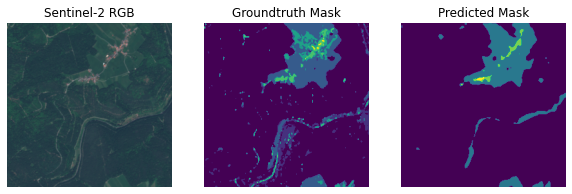

In [45]:
visualize_result(171)